In [42]:
from huggingface_hub import HfApi
import pandas as pd
import itertools
import re
import requests
from bs4 import BeautifulSoup
import time
import json
import os
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

sns.set(style="white", font_scale=2)

from data_analysis.tags import * # tags.py

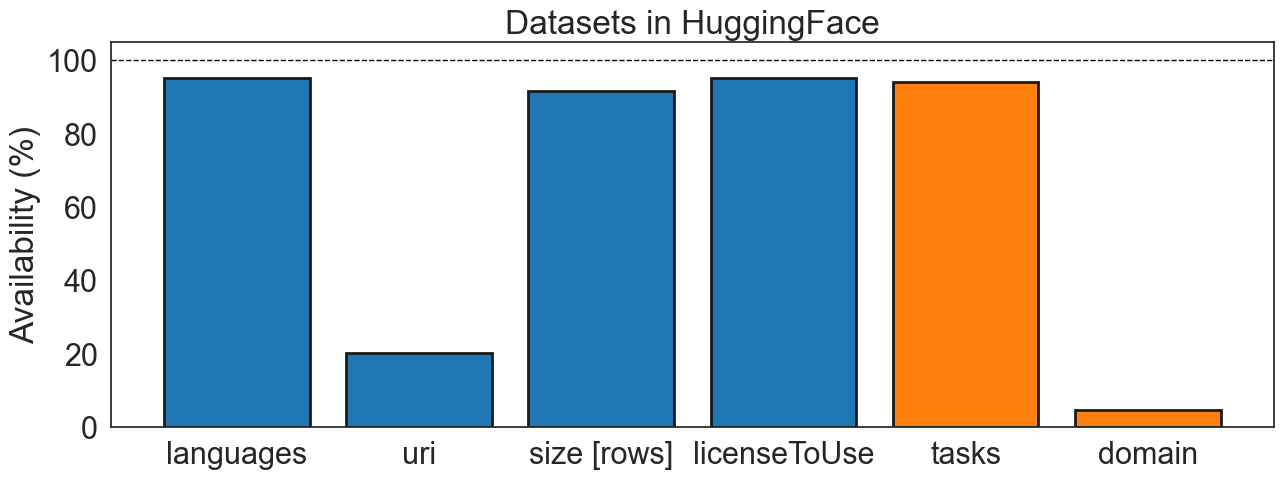

In [14]:
datasets = json.load(open("HF_data/datasets.json", "r"))
df = pd.DataFrame(datasets, dtype=str)
L = df.__len__()

cols = ["languages", "uri", "size [rows]", "licenseToUse"] + ["tasks", "domain"]

df = df.replace("[]", None)

values = []
for col in cols:
    x = df[(df[col].isna())].__len__()
    values.append(100 - x/L * 100)

plt.figure(figsize=(15, 5))   
plt.bar(x=range(cols.__len__()), height = values, color = ['tab:blue' for j in range(4)] + ['tab:orange' for j in range(2)], edgecolor="k", linewidth=2)
plt.title("Datasets in HuggingFace")
plt.ylabel("Availability (%)")
plt.axhline(100, ls="--", color="black", linewidth=1)
plt.xticks(range(cols.__len__()), cols)
plt.show()



In [15]:
models = json.load(open("HF_data/models_new.json", "r"))
df = pd.DataFrame(models, dtype=str)

df = df.replace("[]", None)

L = df.__len__()

hf_api_cols = [
       'languages', 'modelCreator', 'libraryFramework', 'uri',
       'carbonEmission [CO2eq tons]']

hf_derived_cols = ['licenseToUse', 'quantization', 'architecture', 'fineTuned']

new_cols = ['numberOfParameters', "tokenizer", "developers", "contextLength", "version"]
# 'tokenizer', 'likes', 'downloads',
#       'tasks', 'dataset', 'metrics']

cols = hf_api_cols + hf_derived_cols


([<matplotlib.axis.XTick at 0x17cbf7a30>,
 [Text(0, 0, 'languages'),
  Text(1, 0, 'modelCreator'),
  Text(2, 0, 'libraryFramework'),
  Text(3, 0, 'uri'),
  Text(4, 0, 'carbonEmission [CO2eq tons]'),
  Text(5, 0, 'licenseToUse'),
  Text(6, 0, 'quantization'),
  Text(7, 0, 'architecture'),
  Text(8, 0, 'fineTuned')])

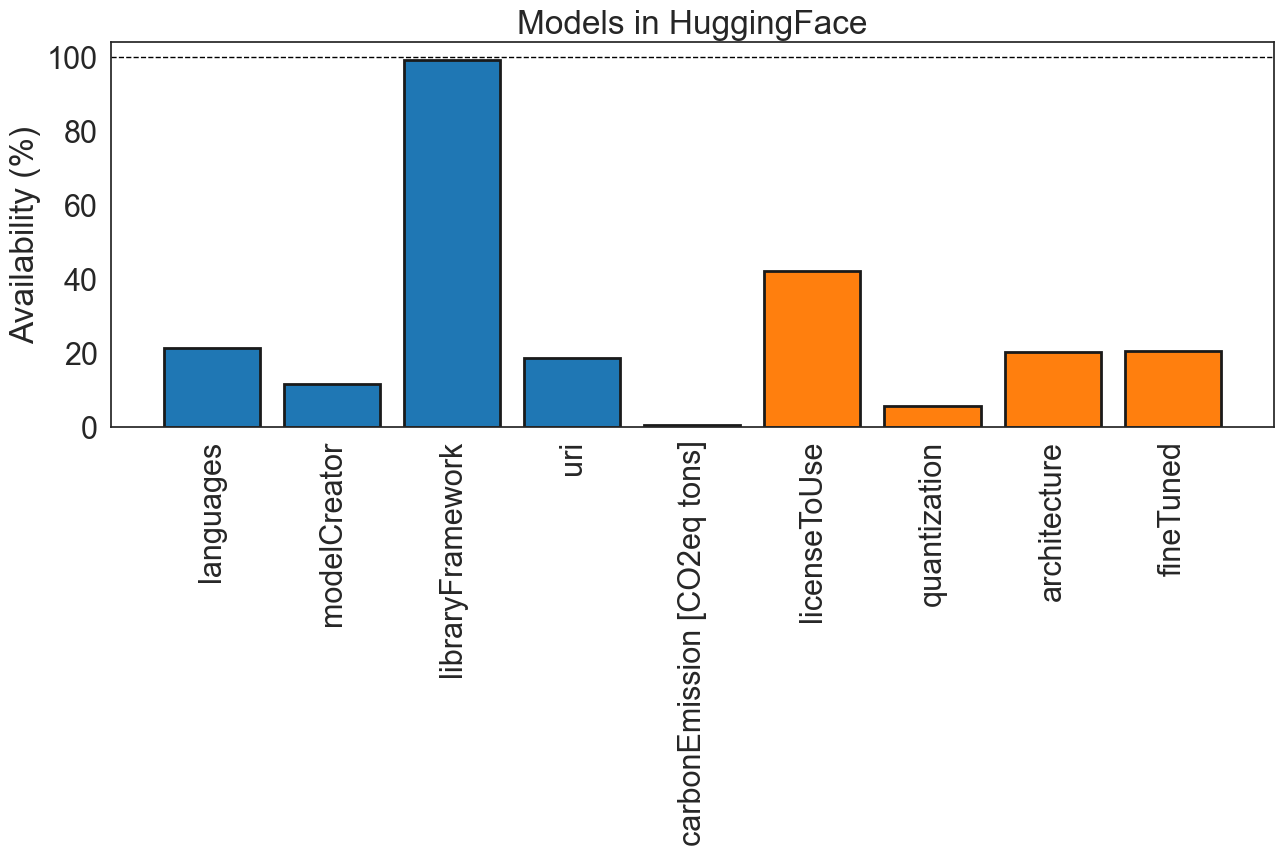

In [16]:
values = []
for col in cols:
    x = df[df[col].isna()].__len__()
    values.append(100 - x/L * 100)

plt.figure(figsize=(15, 5))   
plt.bar(x=range(cols.__len__()), height = values, edgecolor="k", color = ['tab:blue' for j in range(5)] + ['tab:orange' for j in range(5)], linewidth=2)
plt.title("Models in HuggingFace")
plt.ylabel("Availability (%)")
plt.axhline(100, ls="--", color="black", linewidth=1)
plt.xticks(range(cols.__len__()), cols, rotation=90)

In [33]:
values = []
for _, row in df.iterrows():
    missing = 0
    for col in cols:
        if not row[col]:
            missing += 1
    values.append(missing)

In [34]:
new_df = pd.DataFrame()
new_df["missing"] = values
new_df["available"] = 100 - new_df.missing/10 * 100
new_df["likes"] = df.likes.astype(int)
new_df["downloads"] = df.downloads.astype(int)
for col in ["likes", "downloads"]:
    bins = np.percentile(new_df[col], [0, 90, 95, 99, 100])
    # bins = [-1, 0, 1, 10, 100, np.max(new_df[col])]
    new_df[col+"_binned"] = pd.cut(new_df[col], bins = bins)

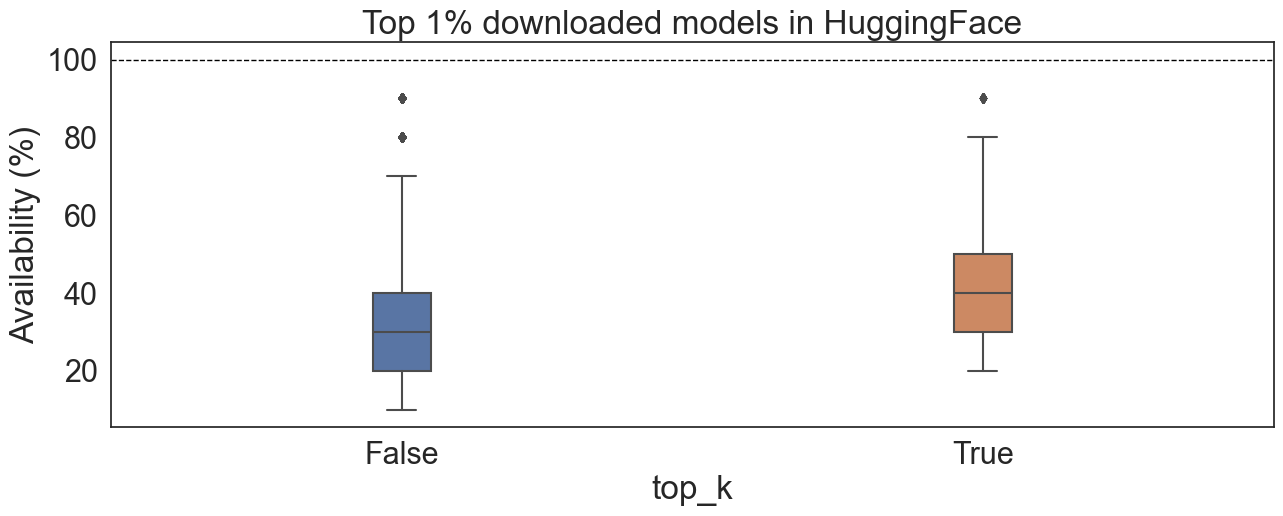

In [8]:
K = 1
M = np.percentile(new_df.downloads, 100-K)
new_df["top_k"] = [True if v >= M else False for v in new_df.downloads]
plt.figure(figsize=(15, 5))   
sns.boxplot(x="top_k", y="available", data=new_df, width =0.1)
plt.title("Top 1% downloaded models in HuggingFace")
plt.ylabel("Availability (%)")
plt.axhline(100, ls="--", color="black", linewidth=1)


/Users/frapierri/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


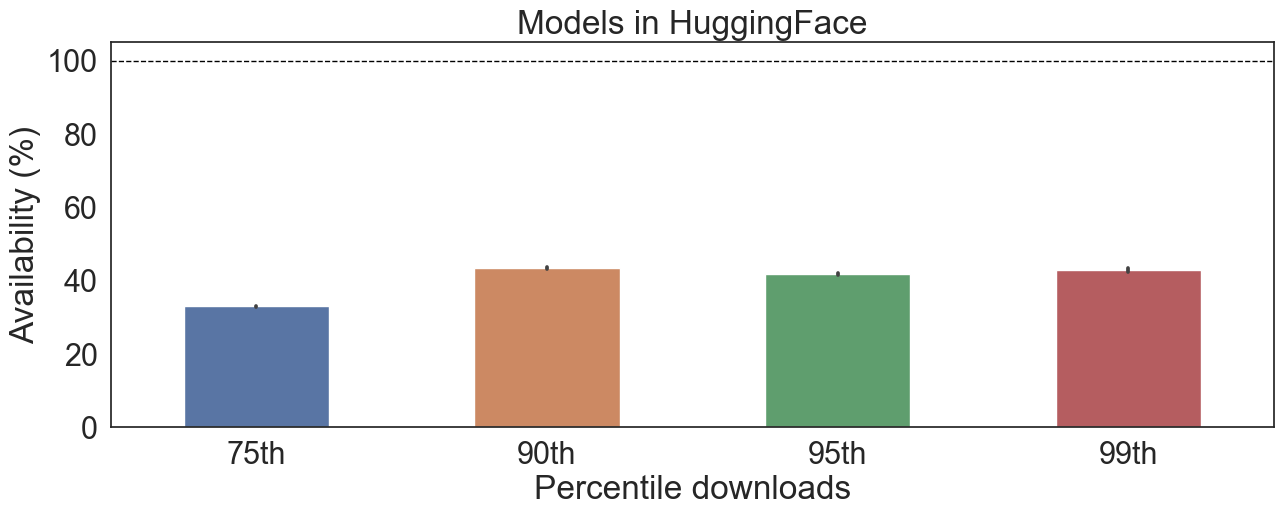

In [20]:
plt.figure(figsize=(15, 5))   
#sns.boxplot(new_df["available"], width =0.1, )
sns.barplot(x="downloads_binned", y="available", data=new_df, width=0.5)
plt.title("Models in HuggingFace")
plt.ylabel("Availability (%)")
plt.xticks(range(4), ["75th", "90th", "95th", "99th"])
plt.xlabel("Percentile downloads")
plt.axhline(100, ls="--", color="black", linewidth=1)

In [54]:
plot_df = pd.DataFrame()
values = []
labels = []
largest = dict()
for k in [100, 500, 1000, 5000]:
    largest[k] = new_df.nlargest(k, "downloads")["downloads"].values[-1]
for ix, row in new_df.iterrows():
    v = row.available
    values.append(v)
    labels.append("All")
    for k in [100, 500, 1000, 5000]:
        if row.downloads >= largest[k]:
            values.append(v)
            labels.append("Top " + str(k))
    if row.downloads == 0:
        values.append(v)
        labels.append("Downloads = 0")


In [56]:
plot_df = pd.DataFrame()
plot_df["value"] = values
plot_df["label"] = labels

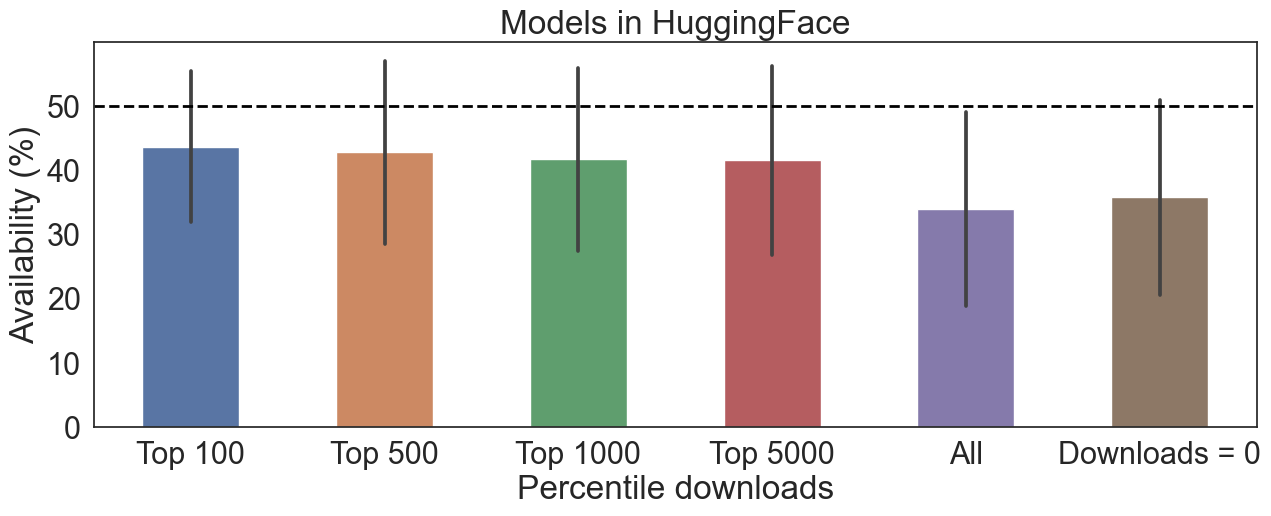

In [72]:
plt.figure(figsize=(15, 5))   
#sns.boxplot(new_df["available"], width =0.1, )
sns.barplot(x="label", y="value", errorbar=('sd'), 
            order = ["Top 100", "Top 500", "Top 1000", "Top 5000", "All", "Downloads = 0"],
            data=plot_df, width=0.5)
plt.title("Models in HuggingFace")
plt.ylabel("Availability (%)")
# plt.xticks(range(4), ["75th", "90th", "95th", "99th"])
plt.xlabel("Percentile downloads")
#plt.axhline(100, ls="--", color="black", linewidth=1)
plt.axhline(50, ls="--", color="black", linewidth=2)